<a href="https://colab.research.google.com/github/eftekhar-hossain/Multimodal-Hateful-Memes/blob/main/hate_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


#Libraries

In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
from bs4 import BeautifulSoup
### ML Librarires--------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
###-------------------------------------------
from keras.utils.vis_utils import plot_model
np.random.seed(42)
import string, spacy,unicodedata, random
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
main_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/"
models_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/"
results_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Results/"
memes_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/"

CPU times: user 6.47 s, sys: 979 ms, total: 7.45 s
Wall time: 15.2 s


In [ ]:
from keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply, concatenate
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.models import load_model
import itertools
from PIL import Image, ImageFile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten,Reshape,dot,multiply
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D,Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam
keras.backend.clear_session()

#Dataset Fetching

In [ ]:
train_data = pd.read_excel(main_path + 'train_hate.xlsx')
valid_data = pd.read_excel(main_path + 'valid_hate.xlsx')
test_data = pd.read_excel(main_path + 'test_hate.xlsx')

In [ ]:
print("Number of Training Data: ",len(train_data))
print("Number of Validation Data: ",len(valid_data))
print("Number of Test Data: ",len(test_data))

In [ ]:
train_data['Label'].value_counts()

not-hate    2092
hate        1275
Name: Label, dtype: int64

In [ ]:
valid_data['Label'].value_counts()

not-hate    223
hate        152
Name: Label, dtype: int64

In [ ]:
test_data['Label'].value_counts()

not-hate    257
hate        159
Name: Label, dtype: int64

In [ ]:
## Replace Names
train_data['enc_label'] = train_data['Label'].replace({'hate':1,'not-hate':0})
valid_data['enc_label'] = valid_data['Label'].replace({'hate':1,'not-hate':0})
test_data['enc_label'] = test_data['Label'].replace({'hate':1,'not-hate':0})

## Display Some Data

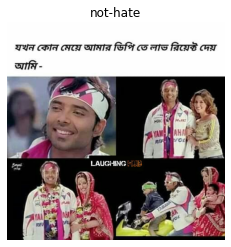

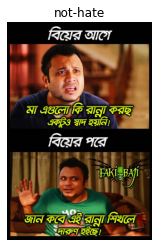

In [ ]:
from matplotlib import image as im
for i in range(2):
  data = im.imread(memes_path+'3300 Memes/'+ train_data['image_name'][i],0)
  plt.figure()
  plt.axis('off')
  plt.imshow(data)
  plt.title(train_data['Label'][i])

In [ ]:
n = 472
from matplotlib import image as im
data = im.imread(memes_path+'3300 Memes/'+ test_data['image_name'][n],0)
plt.figure()
plt.axis('off')
plt.imshow(data)
#plt.title('Human Damage')
plt.savefig(results_path+"472_negative.png",bbox_inches='tight')
test_data['Label'][n]

#Memes Fetching

In [ ]:
## collect image names from the folders
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '' + str(name) for name in DF[Col_name]]
    return img_path


In [ ]:
# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 150*150*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(150,150))
    return(img)

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array
    img_data = image.img_to_array(img)
    # Adding one more dimension to array
    img_data = np.expand_dims(img_data, axis=0)
    #
    img_data = preprocess_input(img_data)
    return(img_data)


In [ ]:
img_dir = memes_path+'3300 Memes/'
# Creating train, test and validation image path
train_img_path = create_img_path(train_data,'image_name', img_dir)
valid_img_path = create_img_path(valid_data,'image_name', img_dir)
test_img_path = create_img_path(test_data,'image_name', img_dir)

In [ ]:
# Create an array of training images
train_images = []
for i in train_img_path:
  input_img = get_input(i)
  input_img = process_input(input_img)
  train_images.append(input_img[0])
  print(i)

# convert into numpy array
train_image = np.array(train_images)
print(train_image.shape)

In [ ]:
import pickle as pkl
with open(main_path+'train_image.pkl','wb') as f:
    pkl.dump(train_image, f)

In [ ]:
# Create an array of test images
valid_images = []
for i in valid_img_path:
  input_img = get_input(i)
  input_img = process_input(input_img)
  valid_images.append(input_img[0])

# convert into numpy array
valid_image = np.array(valid_images)
print(valid_image.shape)

(375, 150, 150, 3)


In [ ]:
import pickle as pkl
with open(main_path+'valid_image.pkl','wb') as f:
    pkl.dump(valid_image, f)

In [ ]:
# Create an array of test images
test_images = []
for i in test_img_path:
  input_img = get_input(i)
  input_img = process_input(input_img)
  test_images.append(input_img[0])

# convert into numpy array
test_image = np.array(test_images)
print(test_image.shape)

(416, 150, 150, 3)


In [ ]:
import pickle as pkl
with open(main_path+'test_image.pkl','wb') as f:
    pkl.dump(test_image, f)

#Image Fetching

In [ ]:
import pickle as pkl

## Train image
with open(main_path+'train_image.pkl','rb') as f:
  train_image = pkl.load(f)
  print("Training Images:-- ",train_image.shape)

## Valid image
with open(main_path+'valid_image.pkl','rb') as f:
  valid_image = pkl.load(f)
  print("Valid Images:-- ",valid_image.shape)

## Test image
with open(main_path+'test_image.pkl','rb') as f:
  test_image = pkl.load(f)
  print("Test Images:-- ",test_image.shape)

Training Images:--  (3365, 150, 150, 3)
Valid Images:--  (375, 150, 150, 3)
Test Images:--  (416, 150, 150, 3)


#Captions Cleaning

In [ ]:
stp_path = '/content/drive/My Drive/Colab Notebooks/NLP Projects/Document Categorization/'
stp = open(stp_path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
   #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  post = post.replace('।', ' ')
  text = ''.join([c for c in post if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower()
  # Stopword
  #result = text.split()
  #text = [word.strip() for word in result if word not in stp ]
  #text =" ".join(text)

  return text

In [ ]:
#Removing punctuations
train_data['cleaned'] = train_data['Captions'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['Captions'].apply(text_cleaning)
test_data['cleaned'] = test_data['Captions'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(100):
  print("Original Data:===\n",train_data.Captions[i],"\nCleaned Data:===\n",train_data.cleaned[i], "\nLabel:== ",train_data.Label[i])

Data samples after cleaning:

Original Data:===
 যখন কোন মেয়ে আমার ডিপি তে লাভ রিয়েক্ট দেয় আমি-  
Cleaned Data:===
 যখন কোন মেয়ে আমার ডিপি তে লাভ রিয়েক্ট দেয় আমি 
Label:==  not-hate
Original Data:===
 বিয়ের আগে মা এগুলো কি রান্না করছ একটুও স্বাদ হয়নি! বিয়ের পরে জান কবে এই রান্না শিখলে দারুণ হইছে! 
Cleaned Data:===
 বিয়ের আগে মা এগুলো কি রান্না করছ একটুও স্বাদ হয়নি বিয়ের পরে জান কবে এই রান্না শিখলে দারুণ হইছে 
Label:==  not-hate
Original Data:===
 চিকচিক করে বালি কোথাও নাই কাঁদা মুখ খানা সাদা তার হাত দুটো কেন কালা ?  
Cleaned Data:===
 চিকচিক করে বালি কোথাও নাই কাঁদা মুখ খানা সাদা তার হাত দুটো কেন কালা 
Label:==  hate
Original Data:===
 বাংলাদেশের বিরুদ্ধে লড়তে প্রস্তুত মিয়ানমার!  আয় থাপ্পরায় ইয়াবার পিনিক নামায় দিমু! 
Cleaned Data:===
 বাংলাদেশের বিরুদ্ধে লড়তে প্রস্তুত মিয়ানমার আয় থাপ্পরায় ইয়াবার পিনিক নামায় দিমু 
Label:==  not-hate
Original Data:===
 যখন  তুমি সবে মাত্র Bathroom থেকে বেরিয়েছো আর সামনে ক্রাশকে দেখতে পাও  
Cleaned Data:===
 যখন তুমি সবে মাত্র bathroom থেকে বেরিয়েছো আর সা

#One Hot Encoding

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['Label']]))

encoded_labels.columns = encoder.get_feature_names(['Label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Hate', 'Label', 'enc_label', 'cleaned',
       'Hate', 'Not-Hate', 'Label_hate', 'Label_not-hate'],
      dtype='object')

In [ ]:
train_data = train_data.rename(columns={'Label_hate':'Hate',
                                        'Label_not-hate':'Not-Hate'
                                       })

In [ ]:
train_data

,image_name,Captions,Label_Hate,Label,enc_label,cleaned,Hate,Not-Hate,Hate,Not-Hate
0,direct-offense (76).jpg,যখন কোন মেয়ে আমার ডিপি তে লাভ রিয়েক্ট দেয় আমি-,not-hate,not-hate,0,মেয়ে ডিপি তে লাভ রিয়েক্ট দেয়,0.0,1.0,0.0,1.0
1,KAM (427).jpg,বিয়ের আগে মা এগুলো কি রান্না করছ একটুও স্বাদ হ...,not-hate,not-hate,0,বিয়ের মা এগুলো রান্না করছ একটুও স্বাদ হয়নি বিয়...,0.0,1.0,0.0,1.0
2,ovodro_img (486).jpg,চিকচিক করে বালি কোথাও নাই কাঁদা মুখ খানা সাদা ...,hate_women,hate,1,চিকচিক বালি কোথাও কাঁদা মুখ খানা সাদা হাত কালা,1.0,0.0,1.0,0.0
3,KAM (225).jpg,বাংলাদেশের বিরুদ্ধে লড়তে প্রস্তুত মিয়ানমার! আ...,not-hate,not-hate,0,বাংলাদেশের বিরুদ্ধে লড়তে প্রস্তুত মিয়ানমার আয় ...,0.0,1.0,0.0,1.0
4,ovodro_img (614).jpg,যখন তুমি সবে মাত্র Bathroom থেকে বেরিয়েছো আর ...,not-hate,not-hate,0,সবে bathroom বেরিয়েছো ক্রাশকে পাও,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3360,KAM (146).jpg,"মামুনি, পড়তে বস! পড়মু না পড়মু না তোরে জুনায়েদে...",not-hate,not-hate,0,মামুনি পড়তে বস পড়মু পড়মু তোরে জুনায়েদের লগে বি...,0.0,1.0,0.0,1.0
3361,bangla-memes (197).jpg,রমযান মাসঃ *approaching* শয়তানঃ বিপদের...,not-hate,not-hate,0,রমযান মাসঃ approaching শয়তানঃ বিপদের গন্ধ পাচ্ছি,0.0,1.0,0.0,1.0
3362,bangla-gag (4).png,GIRLS IN REAL LIFE GIRLS IN FACEBOOK,hate_community,hate,1,girls in real life girls in facebook,1.0,0.0,1.0,0.0
3363,Halal Memes (344).jpg,বোরকাওয়ালী কোন মেয়ের চোখের দিকে তাকানোর পর ! ...,not-hate,not-hate,0,বোরকাওয়ালী মেয়ের চোখের তাকানোর আমিঃ,0.0,1.0,0.0,1.0


#Dataset Statistics

In [ ]:
## Individual tweets length calculation
def char_length(row):
    return len(row.split())


lables = ['Hate','Not-Hate']
# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
        counts[word] = counts.get(word, 0)+1
      # sort the dictionary of word list
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    print(f"\nClass Name:--> {l} ")
    print("Number of Words:{}".format(len(word_list)))
    print("Number of Unique Words:{}".format(len(np.unique(word_list))))
    print("Maximum Caption length: {}".format(max(dataset[dataset[l]==1].cleaned.apply(char_length))))
    print("Minimum Caption length: {}".format(min(dataset[dataset[l]==1].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1].cleaned.apply(char_length))))
    print(color.BOLD+"\nMost Frequent Words:\n"+color.END)
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))


In [ ]:
dataset_statistics(train_data)


Class Name:--> Hate 
Number of Words:12854
Number of Unique Words:5781
Maximum Caption length: 51
Minimum Caption length: 1
Average Words in texts: 10.08156862745098

Most Frequent Words:

you	97
মেয়ে	69
a	59
the	58
সাথে	58
in	57
দিয়ে	55
when	53
to	52
একটা	51

Class Name:--> Not-Hate 
Number of Words:22885
Number of Unique Words:8627
Maximum Caption length: 87
Minimum Caption length: 1
Average Words in texts: 10.94976076555024

Most Frequent Words:

you	150
me	147
when	111
একটা	105
সাথে	97
যায়	94
তোর	93
a	93
আমিঃ	84
দিয়ে	84


In [ ]:
### Plot a Distribution
def sentence_length_per_class(dataset,set_name):
  label = dataset[['Hate','Not-Hate']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l

  labelsplt = ['Hate','Not-Hate' ]
  color = ['red','green']
  bins = [1,5,10,15,20,25,30,35,40,45,50,55,60]
  plt.figure(figsize=(5,3))
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 40, 0, 800])
  plt.xlabel('Length of the Caption')
  plt.ylabel('Number of Captions ')
  plt.legend()
  #plt.savefig(results_path+'length-dist.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()


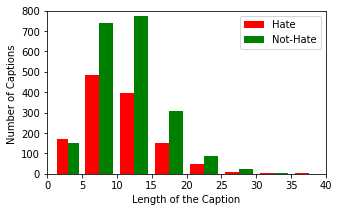

In [ ]:
sentence_length_per_class(train_data,'Training')

##Jacard Similarity

In [ ]:
## Individual tweets length calculation
def char_length(row):
    return len(row.split())

lables = ['Hate','Not-Hate']
# Count number of unique words in each set

final_list = []

for l in lables:
  label_wise_word_list = []
  word_list = [word.strip() for t in list(train_data[train_data[l]==1].cleaned) for word in t.strip().split()]
  counts = dict()
  for word in word_list:
      counts[word] = counts.get(word,0) + 1
      # sort the dictionary of word list
  ordered = sorted(counts.items(), key= lambda item: item[1], reverse = True)
  print(f"\nClass Name:--> {l} ")

  for k,v in ordered[:400]:
    label_wise_word_list.append(k)

  final_list.append(label_wise_word_list)

In [ ]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [ ]:
jaccard_similarity(final_list[0],final_list[1])

0.391304347826087

##Scatter Plot

In [ ]:
!pip install texthero

In [ ]:
import texthero as hero

In [ ]:
train_data['tfidf'] = (hero.tfidf(train_data['cleaned'], max_features=500))
train_data[["tfidf", "Label"]].head(2)

,tfidf,Label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",not-hate
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",not-hate


In [ ]:
train_data['pca'] = hero.pca(train_data['tfidf'])
hero.scatterplot(train_data, col='pca', color='Label', title="PCA Multimodal Hate")

#Evaluation Metrics

In [ ]:
'''Evaluation Parameters'''

def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,target_names=['not-hate','hate']))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

#Callbacks

In [ ]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_with_garbage(model_name):
  accuracy_threshold = 0.98

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  # Garbage Collector - use it like gc.collect()
  import gc
  # Custom Callback To Include in Callbacks List At Training Time
  class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


  acc_callback = myCallback()
  gc_callback = GarbageCollectorCallback()
  # Saved the Best Model
  filepath = models_path+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, gc_callback, checkpoint]

  return callback_list

In [ ]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_check(model_name):
  accuracy_threshold = 0.98

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  # Saved the Best Model
  filepath = models_path+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, checkpoint]

  return callback_list

In [ ]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_data['enc_label']),
                                        y = train_data['enc_label']
                                    )
weight = {i : class_weights[i] for i in range(2)}
weight

{0: 0.8050239234449761, 1: 1.3196078431372549}

#Visual Modality

In [ ]:
def visual_models(pretrained_model):
  '''
      Input: Pretrained Models weight
  '''
  base_model = pretrained_model
  base_model.trainable = False
  y = base_model.output
  pool = GlobalAveragePooling2D()(y)
  #flatten = Flatten()(pool)
  output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
  img_model = Model(inputs=base_model.input, outputs=output)

  return img_model

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
vgg16 = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

##VGG19

In [ ]:
vgg19_model = visual_models(vgg19)
vgg19_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(),
                    metrics = ["accuracy"])

In [ ]:
keras.backend.clear_session()
vgg19_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=15,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('vgg19')
              )

In [ ]:
 # Prediction
model = load_model(models_path+"vgg19.h5")
pred = model.predict(test_image)
y_pred = (pred>0.5).astype(int)
y_pred

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[155 102]
 [ 73  86]]
              precision    recall  f1-score   support

    not-hate       0.68      0.60      0.64       257
        hate       0.46      0.54      0.50       159

    accuracy                           0.58       416
   macro avg       0.57      0.57      0.57       416
weighted avg       0.59      0.58      0.58       416

Accuracy :  0.5793269230769231
Precison :  0.5948292183507049
Recall :  0.5793269230769231
F1 :  0.5843286570970845


##VGG16

In [ ]:
keras.backend.clear_session()
vgg16_model = visual_models(vgg16)
vgg16_model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(),
                    metrics = ["accuracy"])

In [ ]:
vgg16_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=15,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('vgg16')
              )

In [ ]:
 # Prediction
model = load_model(models_path+"vgg16.h5")
pred = model.predict(test_image)
y_pred = (pred>0.5).astype(int)

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[193  64]
 [ 84  75]]
              precision    recall  f1-score   support

    not-hate       0.70      0.75      0.72       257
        hate       0.54      0.47      0.50       159

    accuracy                           0.64       416
   macro avg       0.62      0.61      0.61       416
weighted avg       0.64      0.64      0.64       416

Accuracy :  0.6442307692307693
Precison :  0.6366739155190705
Recall :  0.6442307692307693
F1 :  0.6389545495853467


##ResNet50

In [ ]:
keras.backend.clear_session()
resnet_model = visual_models(resnet)
resnet_model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(),
                    metrics = ["accuracy"])

In [ ]:
resnet_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=15,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('resnet')
              )

In [ ]:
# Prediction
model = load_model(models_path+"resnet.h5")
pred = model.predict(test_image)
y_pred = (pred>0.3).astype(int)

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[177  80]
 [ 70  89]]
              precision    recall  f1-score   support

    not-hate       0.72      0.69      0.70       257
        hate       0.53      0.56      0.54       159

    accuracy                           0.64       416
   macro avg       0.62      0.62      0.62       416
weighted avg       0.64      0.64      0.64       416

Accuracy :  0.6394230769230769
Precison :  0.6439897108497233
Recall :  0.6394230769230769
F1 :  0.6413425243455732


##Visual Attention

In [ ]:
pip install visual-attention-tf

In [ ]:
from visual_attention import PixelAttention2D , ChannelAttention2D,EfficientChannelAttention2D

In [ ]:
def visual_models(pretrained_model):
  '''
      Input: Pretrained Models weight
  '''
  base_model = pretrained_model
  base_model.trainable = False
  y = base_model.layers[-2].output
  #EfficientChannelAttention_cnn = EfficientChannelAttention2D(y.shape[-1])(y)
  attention_cnn = PixelAttention2D(y.shape[-1])(y)
  pool = GlobalAveragePooling2D()(attention_cnn)
  #flatten = Flatten()(att)
  output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
  img_model = Model(inputs=base_model.input, outputs=output)

  return img_model

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
vgg16 = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

## VGG16+PixelAttention

In [ ]:
keras.backend.clear_session()
vgg16_att_model = visual_models(vgg16)
vgg16_att_model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(),
                    metrics = ["accuracy"])

In [ ]:
vgg16_att_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=10,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('vgg16-att-channel')
              )

In [ ]:
vgg16_att_model.save_weights(models_path+'vgg16-att-channel')

In [ ]:
 # Prediction
model = vgg16_att_model.load_weights(models_path+"vgg16-att-channel")
pred = vgg16_att_model.predict(test_image)
y_pred = (pred>0.4).astype(int)

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[177  80]
 [ 71  88]]
              precision    recall  f1-score   support

    not-hate       0.71      0.69      0.70       257
        hate       0.52      0.55      0.54       159

    accuracy                           0.64       416
   macro avg       0.62      0.62      0.62       416
weighted avg       0.64      0.64      0.64       416

Accuracy :  0.6370192307692307
Precison :  0.6411276475540588
Recall :  0.6370192307692307
F1 :  0.6387798968675978


## VGG19 + PixelAttention

In [ ]:
keras.backend.clear_session()
vgg19_att_model = visual_models(vgg19)
vgg19_att_model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(),
                    metrics = ["accuracy"])

In [ ]:
vgg19_att_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=10,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('vgg19-att-channel')
              )

In [ ]:
vgg19_att_model.save_weights(models_path+'vgg19-att-channel')

In [ ]:
 # Prediction
model = vgg19_att_model.load_weights(models_path+"vgg19-att-channel")
pred = vgg19_att_model.predict(test_image)
y_pred = (pred>0.4).astype(int)

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[173  84]
 [ 81  78]]
              precision    recall  f1-score   support

    not-hate       0.68      0.67      0.68       257
        hate       0.48      0.49      0.49       159

    accuracy                           0.60       416
   macro avg       0.58      0.58      0.58       416
weighted avg       0.60      0.60      0.60       416

Accuracy :  0.6033653846153846
Precison :  0.6048049582744464
Recall :  0.6033653846153846
F1 :  0.6040545279199101


## ResNet50 + PixelAttention

In [ ]:
keras.backend.clear_session()
resnet_att_model = visual_models(resnet)
resnet_att_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(),
                    metrics = ["accuracy"])

In [ ]:
resnet_att_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=10,
              batch_size =16,
              validation_data = (valid_image,valid_data['enc_label']),
              verbose = 1,
              class_weight = weight,
              callbacks = callbacks_check('resnet-att-channel')
              )

In [ ]:
resnet_att_model.save_weights(models_path+'resnet-att-channel')

In [ ]:
 # Prediction
model = resnet_att_model.load_weights(models_path+"resnet-att-channel")
pred = resnet_att_model.predict(test_image)
y_pred = (pred>0.5).astype(int)

In [ ]:
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[134 123]
 [ 46 113]]
              precision    recall  f1-score   support

    not-hate       0.74      0.52      0.61       257
        hate       0.48      0.71      0.57       159

    accuracy                           0.59       416
   macro avg       0.61      0.62      0.59       416
weighted avg       0.64      0.59      0.60       416

Accuracy :  0.59375
Precison :  0.6429172551789077
Recall :  0.59375
F1 :  0.5975556150971817


#Textual Models

##Keras Tokenizer

In [ ]:
''' Tokenizer '''

def text_tokenizer(train_data,test_data,vocabulary,max_len,sample_text_num):

  tokenizer = Tokenizer(num_words = vocabulary ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                        split=' ', char_level=False, oov_token='<oov>', document_count=0)
  tokenizer.fit_on_texts(train_data['Captions'])
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1

  # Training Sequences
  train_sequences = tokenizer.texts_to_sequences(train_data['Captions'])
  train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)


  # Validation Sequences
  valid_sequences = tokenizer.texts_to_sequences(valid_data['Captions'])
  valid_pad_sequences =  keras.preprocessing.sequence.pad_sequences(valid_sequences, value=0.0, padding='post', maxlen= max_len)


  # Test Sequences
  test_sequences = tokenizer.texts_to_sequences(test_data['Captions'])
  test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)


  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(train_data.Captions[sample_text_num],"\n",train_sequences[sample_text_num])
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,"\n",train_pad_sequences[sample_text_num])

  return train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index


vocabulary = 15000
max_len = 50
sample_text_num = 10

## Call Tokenizer
train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index =  text_tokenizer(train_data,test_data,
                                                                      vocabulary,max_len,sample_text_num)

print("Number of Train Sequences :" ,train_pad_sequences.shape)
print("Number of Test Sequences :" ,test_pad_sequences.shape)
print("Vocabulary Size: ",vocab_size)


			====== Encoded Sequences ====== 

ভার্সিটির বড় ভাই    আমি*    কুমুদিনীর মেয়ে  
 [1442, 63, 39, 3, 467, 41]

			====== Paded Sequences ======
 
 [1442   63   39    3  467   41    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Number of Train Sequences : (3365, 50)
Number of Test Sequences : (416, 50)
Vocabulary Size:  11993


##BiLSTM+CNN

In [ ]:
##### LSTM-CNN Model ####
lc_text_inputs = Input(shape=(max_len,))
lc_embedding_layer = Embedding(vocab_size,64)(lc_text_inputs)
LSTM_Layer = Bidirectional(LSTM(32,return_sequences=True))(lc_embedding_layer)
lc_conv1 = Conv1D(32,2,activation='relu')(LSTM_Layer)
lc_pool1 = MaxPooling1D(2)(lc_conv1)
lc_flat = Flatten()(lc_pool1)
lc_dense_layer_1 = Dense(1, activation='sigmoid')(lc_flat)
cnn_lstm_model = Model(inputs=lc_text_inputs, outputs=lc_dense_layer_1)

In [ ]:
keras.backend.clear_session()
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


cnn_lstm_model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=20,
    batch_size =32,
    validation_data = (valid_pad_sequences,valid_data['enc_label']),
    verbose = 1,
    class_weight = weight,
    callbacks = callbacks_check('lstm-cnn'))

Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5590
Epoch 00001: val_accuracy improved from -inf to 0.63467, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/lstm-cnn.h5
106/106 [==============================] - 17s 18ms/step - loss: 0.6764 - accuracy: 0.5590 - val_loss: 0.6300 - val_accuracy: 0.6347
Epoch 2/20
102/106 [===========================>..] - ETA: 0s - loss: 0.4224 - accuracy: 0.8021
Epoch 00002: val_accuracy did not improve from 0.63467
106/106 [==============================] - 1s 9ms/step - loss: 0.4203 - accuracy: 0.8033 - val_loss: 0.6888 - val_accuracy: 0.6293
Epoch 3/20
102/106 [===========================>..] - ETA: 0s - loss: 0.1310 - accuracy: 0.9556
Epoch 00003: val_accuracy did not improve from 0.63467
106/106 [==============================] - 1s 9ms/step - loss: 0.1318 - accuracy: 0.9545 - val_loss: 1.1998 - val_accuracy: 0.6187
Epoch 4/20
102/106 [===

In [ ]:
 # Prediction
model = load_model(models_path+"lstm-cnn.h5")
pred = model.predict(test_pad_sequences)
y_pred = (pred>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

##LSTM+ATT

In [ ]:
def create_lstm_attention_model (max_len,vocab_size,embedding_dimension):

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(max_len,), dtype="int32")
  embedded_sequences = Embedding(vocab_size, embedding_dimension)(sequence_input)
  #lstm = Bidirectional(LSTM(128, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(32, return_sequences=True, return_state=True), name="bi_lstm_1")(embedded_sequences)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  #dense1 = Dense(20, activation="relu")(context_vector)
  #dropout = Dropout(0.01)(dense1)
  output = Dense(1, activation="sigmoid")(context_vector)

  lstm_attention_model = Model(inputs=sequence_input, outputs=output)

  return lstm_attention_model


In [ ]:
filepath = models_path + 'lstm_att.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
maximum_length = 50
vocabulary_size = vocab_size
embedding_dimension = 64
keras.backend.clear_session()
####

model = create_lstm_attention_model (maximum_length,vocabulary_size,embedding_dimension)
model.compile(loss='binary_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy'])

model.fit(train_pad_sequences,train_data['enc_label'],
                    batch_size=32,
                    epochs=10,
                    validation_data = (valid_pad_sequences, valid_data['enc_label']),
                    verbose =1,
                    callbacks = [checkpoint] )

In [ ]:
model = create_lstm_attention_model (maximum_length,vocabulary_size,embedding_dimension)
model.load_weights(models_path + 'lstm_att.h5')
y_pred = (model.predict(test_pad_sequences)>0.5).astype(int)
print_metrices(y_true,y_pred)

[[194  63]
 [ 81  78]]
              precision    recall  f1-score   support

    not-hate       0.71      0.75      0.73       257
        hate       0.55      0.49      0.52       159

    accuracy                           0.65       416
   macro avg       0.63      0.62      0.62       416
weighted avg       0.65      0.65      0.65       416

Accuracy :  0.6538461538461539
Precison :  0.6472578485344442
Recall :  0.6538461538461539
F1 :  0.6493175245806824


##Transformers

In [ ]:
!pip install transformers

In [ ]:
############################## Sentence Encoding for Transformers

def bert_encode(data,maximum_length,tokenizer) :
  input_ids = []
  attention_masks = []


  for i in range(len(data.Captions)):
      encoded = tokenizer.encode_plus(

        data.Captions[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,

      )

      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
#######################################             Model Defination
def create_model(bert_model,max_len):
  input_ids = Input(shape=(max_len,),dtype='int32')
  attention_masks = Input(shape=(max_len,),dtype='int32')
  output = bert_model([input_ids,attention_masks])
  output = output[0]                                ## 0 for distillbert
  #output = Dense(32,activation='relu')(output[:, 0, :])
  #output = Dropout(0.1)(output)
  output = Dense(1,activation='sigmoid')(output[:, 0, :])
  model = Model(inputs = [input_ids,attention_masks],outputs = output)
  return model

###Bangla-BERT

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_data,50,tokenizer)
valid_input_ids,valid_attention_masks = bert_encode(valid_data,50,tokenizer)
test_input_ids,test_attention_masks = bert_encode(test_data,50,tokenizer)

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('sagorsarker/bangla-bert-base')

In [ ]:
### Checkpoint
filepath = models_path + 'bangla-bert-1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = create_model(bert_model,50)
model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_input_ids,valid_attention_masks], valid_data['enc_label']),
                    epochs=6,
                    batch_size=16,
                    callbacks = [checkpoint],
                    # class_weight = weight
          )

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9281
Epoch 00001: val_accuracy improved from -inf to 0.62133, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/bangla-bert-1.h5
211/211 [==============================] - 65s 237ms/step - loss: 0.1481 - accuracy: 0.9281 - val_loss: 1.7399 - val_accuracy: 0.6213
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9459
Epoch 00002: val_accuracy improved from 0.62133 to 0.66933, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/bangla-bert-1.h5
211/211 [==============================] - 53s 253ms/step - loss: 0.1064 - accuracy: 0.9459 - val_loss: 1.7905 - val_accuracy: 0.6693
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9370
Epoch 00003: val_accuracy did not improve from 0.66933
211/211 [==

In [ ]:
#bangla-bert ---> 1e-5
#bangla-bert ---->3e-5

In [ ]:
model2 = create_model(bert_model,50)
model2.load_weights(models_path+"bangla-bert-1.h5")
y_pred = (model2.predict([test_input_ids,test_attention_masks])>0.5).astype(int)
#y_pred = np.argmax(pred,axis=1)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[210  47]
 [ 95  64]]
              precision    recall  f1-score   support

    not-hate       0.69      0.82      0.75       257
        hate       0.58      0.40      0.47       159

    accuracy                           0.66       416
   macro avg       0.63      0.61      0.61       416
weighted avg       0.65      0.66      0.64       416

Accuracy :  0.6586538461538461
Precison :  0.645736767662997
Recall :  0.6586538461538461
F1 :  0.6428890257626912


###M-BERT

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_data,50,tokenizer)
valid_input_ids,valid_attention_masks = bert_encode(valid_data,50,tokenizer)
test_input_ids,test_attention_masks = bert_encode(test_data,50,tokenizer)

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
### Checkpoint
filepath = models_path + 'm-bert.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = create_model(bert_model,50)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_input_ids,valid_attention_masks], valid_data['enc_label']),
                    epochs=6,
                    batch_size=16,
                    callbacks = [checkpoint]
                    # class_weight = weight
          )

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.6241
Epoch 00001: val_accuracy improved from -inf to 0.62133, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/m-bert.h5
211/211 [==============================] - 67s 244ms/step - loss: 0.6549 - accuracy: 0.6241 - val_loss: 0.6528 - val_accuracy: 0.6213
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6493
Epoch 00002: val_accuracy did not improve from 0.62133
211/211 [==============================] - 47s 221ms/step - loss: 0.6219 - accuracy: 0.6493 - val_loss: 0.6456 - val_accuracy: 0.6027
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7013
Epoch 00003: val_accuracy did not improve from 0.62133
211/211 [==============================] - 47s 220ms/step - loss: 0.5603 - accuracy: 0.7013 - val_loss: 0.6832 - val_accuracy: 0.6080
Epoch 4/6
211/211 [==

In [ ]:
model2 = create_model(bert_model,50)
model2.load_weights(models_path+"m-bert.h5")
y_pred = (model2.predict([test_input_ids,test_attention_masks])>0.5).astype(int)
#y_pred = np.argmax(pred,axis=1)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[214  43]
 [105  54]]
              precision    recall  f1-score   support

    not-hate       0.67      0.83      0.74       257
        hate       0.56      0.34      0.42       159

    accuracy                           0.64       416
   macro avg       0.61      0.59      0.58       416
weighted avg       0.63      0.64      0.62       416

Accuracy :  0.6442307692307693
Precison :  0.6272187197800422
Recall :  0.6442307692307693
F1 :  0.620296641292735


###XLM-R

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_data,50,tokenizer)
val_input_ids,val_attention_masks = bert_encode(valid_data,50,tokenizer)
test_input_ids,test_attention_masks = bert_encode(test_data,50,tokenizer)

In [ ]:
from transformers import TFXLMRobertaModel
xlm_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
### Checkpoint
filepath = models_path + 'xlm-r.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
keras.backend.clear_session()
model = create_model(xlm_model,50)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit([train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([val_input_ids,val_attention_masks],valid_data['enc_label']),
                    epochs=6,
                    batch_size=16,
                    callbacks = [checkpoint])

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5403
Epoch 00001: val_accuracy improved from -inf to 0.61067, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-r.h5
211/211 [==============================] - 87s 340ms/step - loss: 0.6873 - accuracy: 0.5403 - val_loss: 0.6312 - val_accuracy: 0.6107
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6294
Epoch 00002: val_accuracy did not improve from 0.61067
211/211 [==============================] - 57s 272ms/step - loss: 0.6170 - accuracy: 0.6294 - val_loss: 0.6197 - val_accuracy: 0.6027
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.6716
Epoch 00003: val_accuracy improved from 0.61067 to 0.70400, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-r.h5
211/211 [==================

In [ ]:
model1 = create_model(xlm_model,50)
model1.load_weights(models_path+"xlm-r.h5")

y_pred = (model1.predict([test_input_ids,test_attention_masks])>0.5).astype(int)
#y_pred = np.argmax(pred,axis=1)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[200  57]
 [ 86  73]]
              precision    recall  f1-score   support

    not-hate       0.70      0.78      0.74       257
        hate       0.56      0.46      0.51       159

    accuracy                           0.66       416
   macro avg       0.63      0.62      0.62       416
weighted avg       0.65      0.66      0.65       416

Accuracy :  0.65625
Precison :  0.6466463824636901
Recall :  0.65625
F1 :  0.6481823554901324


#Multimodal Models

In [ ]:
#######################################             Model Defination
def create_model(bert_model,max_len):
  input_ids = Input(shape=(max_len,),dtype='int32')
  attention_masks = Input(shape=(max_len,),dtype='int32')
  output = bert_model([input_ids,attention_masks])
  output = output[0]                                ## 0 for distillbert
  output = Dense(10,activation='relu')(output[:, 0, :])
  #output = Dropout(0.1)(output)
  #output = Dense(1,activation='sigmoid')(output[:, 0, :])
  model = Model(inputs = [input_ids,attention_masks],outputs = output)
  return model

##VGG16 + Bangla-BERT

In [ ]:
## VGG16
base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
base_model.trainable = False
y = base_model.output
pool = GlobalAveragePooling2D()(y)
#flatten = Flatten()(pool)
fc_layer_v = Dense(10, activation='relu')(pool)
#output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
img_model = Model(inputs=base_model.input, outputs=fc_layer_v)


# text model
text_model = create_model(bert_model,50)

# Fusion
con_layer = keras.layers.concatenate([img_model.output, text_model.output])
final_dense = Dense(4, activation="relu")(con_layer)
dropout = Dropout(0.1)(final_dense)
out = Dense(1,activation='sigmoid')(dropout)
com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)
#com_model.summary()

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
### Checkpoint
filepath = models_path + 'b-bert+vgg19.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = com_model
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_image,train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_image, valid_input_ids,valid_attention_masks], valid_data['enc_label']),
                    epochs=6,
                    batch_size=16,
                    callbacks = [checkpoint],
                    # class_weight = weight
          )

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 1.0330 - accuracy: 0.7076
Epoch 00001: val_accuracy improved from -inf to 0.64533, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/b-bert+vgg19.h5
211/211 [==============================] - 80s 302ms/step - loss: 1.0330 - accuracy: 0.7076 - val_loss: 1.0597 - val_accuracy: 0.6453
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.8053
Epoch 00002: val_accuracy did not improve from 0.64533
211/211 [==============================] - 57s 269ms/step - loss: 0.4685 - accuracy: 0.8053 - val_loss: 0.9979 - val_accuracy: 0.6293
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8229
Epoch 00003: val_accuracy did not improve from 0.64533
211/211 [==============================] - 56s 266ms/step - loss: 0.4391 - accuracy: 0.8229 - val_loss: 1.1385 - val_accuracy: 0.6240
Epoch 4/6
211/2

In [ ]:
#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[198  59]
 [ 87  72]]
              precision    recall  f1-score   support

    not-hate       0.69      0.77      0.73       257
        hate       0.55      0.45      0.50       159

    accuracy                           0.65       416
   macro avg       0.62      0.61      0.61       416
weighted avg       0.64      0.65      0.64       416

Accuracy :  0.6490384615384616
Precison :  0.6392708687455575
Recall :  0.6490384615384616
F1 :  0.6411609179089139


In [ ]:
## for VGG19
#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[182  75]
 [ 62  97]]
              precision    recall  f1-score   support

    not-hate       0.75      0.71      0.73       257
        hate       0.56      0.61      0.59       159

    accuracy                           0.67       416
   macro avg       0.65      0.66      0.66       416
weighted avg       0.68      0.67      0.67       416

Accuracy :  0.6706730769230769
Precison :  0.6763589566409572
Recall :  0.6706730769230769
F1 :  0.6728675173473644


##VGG16 (Attention) + Bangla-BERT

In [ ]:
## VGG16 or VGG19
base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
#base_model = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
base_model.trainable = False
y = base_model.layers[-2].output
  #EfficientChannelAttention_cnn = EfficientChannelAttention2D(y.shape[-1])(y)
attention_cnn = PixelAttention2D(y.shape[-1])(y)
pool = GlobalAveragePooling2D()(attention_cnn)
fc_layer_v = Dense(10, activation='relu')(pool)
#output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
img_model = Model(inputs=base_model.input, outputs=fc_layer_v)


# text model
text_model = create_model(bert_model,50)

# Fusion
con_layer = keras.layers.concatenate([img_model.output, text_model.output])
final_dense = Dense(4, activation="relu")(con_layer)
dropout = Dropout(0.1)(final_dense)
out = Dense(1,activation='sigmoid')(dropout)
com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)
#com_model.summary()

In [ ]:
### Checkpoint
filepath = models_path + 'b-bert+vgg19-att.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = com_model
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_image,train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_image, valid_input_ids,valid_attention_masks], valid_data['enc_label']),
                    epochs=10,
                    batch_size=16,
                    callbacks = [checkpoint],
                    # class_weight = weight
          )

Epoch 1/10
211/211 [==============================] - ETA: 0s - loss: 1.9835 - accuracy: 0.6933
Epoch 00001: val_accuracy improved from -inf to 0.58667, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/b-bert+vgg19-att.h5
211/211 [==============================] - 80s 306ms/step - loss: 1.9835 - accuracy: 0.6933 - val_loss: 1.6437 - val_accuracy: 0.5867
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.7406
Epoch 00002: val_accuracy improved from 0.58667 to 0.58933, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/b-bert+vgg19-att.h5
211/211 [==============================] - 64s 302ms/step - loss: 1.0103 - accuracy: 0.7406 - val_loss: 1.3533 - val_accuracy: 0.5893
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 0.8120 - accuracy: 0.7694
Epoch 00003: val_accuracy improved from 0.58933 to 0.5920

In [ ]:
#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.50).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[195  62]
 [ 96  63]]
              precision    recall  f1-score   support

    not-hate       0.67      0.76      0.71       257
        hate       0.50      0.40      0.44       159

    accuracy                           0.62       416
   macro avg       0.59      0.58      0.58       416
weighted avg       0.61      0.62      0.61       416

Accuracy :  0.6201923076923077
Precison :  0.6066165741475019
Recall :  0.6201923076923077
F1 :  0.6092396956133206


In [ ]:
## For VGG19

#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.50).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[135 122]
 [ 44 115]]
              precision    recall  f1-score   support

    not-hate       0.75      0.53      0.62       257
        hate       0.49      0.72      0.58       159

    accuracy                           0.60       416
   macro avg       0.62      0.62      0.60       416
weighted avg       0.65      0.60      0.60       416

Accuracy :  0.6009615384615384
Precison :  0.6513911403284504
Recall :  0.6009615384615384
F1 :  0.6045669735463315


##VGG19 + XLM-R

In [ ]:
## VGG16
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
base_model.trainable = False
y = base_model.output
pool = GlobalAveragePooling2D()(y)
#flatten = Flatten()(pool)
fc_layer_v = Dense(10, activation='relu')(pool)
#output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
img_model = Model(inputs=base_model.input, outputs=fc_layer_v)


# text model
text_model = create_model(xlm_model,50)

# Fusion
con_layer = keras.layers.concatenate([img_model.output, text_model.output])
final_dense = Dense(4, activation="relu")(con_layer)
dropout = Dropout(0.1)(final_dense)
out = Dense(1,activation='sigmoid')(dropout)
com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)
#com_model.summary()

In [ ]:
### Checkpoint
filepath = models_path + 'xlmr+vgg16.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = com_model
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_image,train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_image, val_input_ids,val_attention_masks], valid_data['enc_label']),
                    epochs=5,
                    batch_size=16,
                    callbacks = [checkpoint],
                    # class_weight = weight
          )

Epoch 1/5
211/211 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.5539
Epoch 00001: val_accuracy improved from -inf to 0.56800, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlmr+vgg16.h5
211/211 [==============================] - 158s 392ms/step - loss: 0.7172 - accuracy: 0.5539 - val_loss: 0.7038 - val_accuracy: 0.5680
Epoch 2/5
211/211 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.5828
Epoch 00002: val_accuracy improved from 0.56800 to 0.58133, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlmr+vgg16.h5
211/211 [==============================] - 80s 379ms/step - loss: 0.7019 - accuracy: 0.5828 - val_loss: 0.7012 - val_accuracy: 0.5813
Epoch 3/5
211/211 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5947
Epoch 00003: val_accuracy improved from 0.58133 to 0.58667, saving mode

In [ ]:
## For VGG19

#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.40).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[158  99]
 [ 75  84]]
              precision    recall  f1-score   support

    not-hate       0.68      0.61      0.64       257
        hate       0.46      0.53      0.49       159

    accuracy                           0.58       416
   macro avg       0.57      0.57      0.57       416
weighted avg       0.59      0.58      0.59       416

Accuracy :  0.5817307692307693
Precison :  0.5943708766080891
Recall :  0.5817307692307693
F1 :  0.5861635544906223


In [ ]:
## For VGG16

#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg16.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.50).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[246  11]
 [153   6]]
              precision    recall  f1-score   support

    not-hate       0.62      0.96      0.75       257
        hate       0.35      0.04      0.07       159

    accuracy                           0.61       416
   macro avg       0.48      0.50      0.41       416
weighted avg       0.52      0.61      0.49       416

Accuracy :  0.6057692307692307
Precison :  0.5157903242268568
Recall :  0.6057692307692307
F1 :  0.4894012237762238


##VGG19 + Bangla-BERT (with Cross Modal)

In [ ]:
#######################################             Model Defination
def create_model(bert_model,max_len):
  input_ids = Input(shape=(max_len,),dtype='int32')
  attention_masks = Input(shape=(max_len,),dtype='int32')
  output = bert_model([input_ids,attention_masks])
  output = output[0]                                ## 0 for distillbert
  output = Dense(1024,activation='relu')(output[:, 0, :])
  #output = Dropout(0.1)(output)
  #output = Dense(1,activation='sigmoid')(output[:, 0, :])
  model = Model(inputs = [input_ids,attention_masks],outputs = output)
  return model

In [ ]:
def bi_modal_attention(x, y):

    '''
    .  stands for dot product
    *  stands for elemwise multiplication
    {} stands for concatenation

    m1 = x . transpose(y) ||  m2 = y . transpose(x)
    n1 = softmax(m1)      ||  n2 = softmax(m2)
    o1 = n1 . y           ||  o2 = m2 . x
    a1 = o1 * x           ||  a2 = o2 * y

    return {a1, a2}

    '''

    m1 = dot([x, y], axes=[2, 2])
    n1 = Activation('softmax')(m1)
    o1 = dot([n1, y], axes=[2, 1])
    a1 = multiply([o1, x])

    m2 = dot([y, x], axes=[2, 2])
    n2 = Activation('softmax')(m2)
    o2 = dot([n2, x], axes=[2, 1])
    a2 = multiply([o2, y])

    return concatenate([a1, a2])


In [ ]:
## VGG19
base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
base_model.trainable = False
y = base_model.output
pool = GlobalAveragePooling2D()(y)
#flatten = Flatten()(pool)
fc_layer_v = Dense(1024, activation='relu')(pool)
v = Reshape((32,32))(fc_layer_v)
#output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
img_model = Model(inputs=base_model.input, outputs=fc_layer_v)


# text model
text_model = create_model(bert_model,50)
t = Reshape((32,32))(text_model.output)
vt_att = bi_modal_attention(v, t)
flat = Flatten()(vt_att)
# l1 =Dense(64, activation="relu")(con_layer)
# Fusion
con_layer = keras.layers.concatenate([img_model.output, text_model.output,flat])
#final_dense = Dense(10, activation="relu")(con_layer)
#dropout = Dropout(0.3)(final_dense)
out = Dense(1,activation='sigmoid')(con_layer)
com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)
#com_model.summary()

In [ ]:
### Checkpoint
filepath = models_path + 'b-bert+vgg19_cross-1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )


In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = com_model
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
model.fit([train_image,train_input_ids,train_attention_masks],
                    train_data['enc_label'],
                    validation_data = ([valid_image, valid_input_ids,valid_attention_masks], valid_data['enc_label']),
                    epochs=10,
                    batch_size=16,
                    callbacks = [checkpoint],
                    # class_weight = weight
          )

Epoch 1/10
211/211 [==============================] - ETA: 0s - loss: 0.8316 - accuracy: 0.7596
Epoch 00001: val_accuracy improved from -inf to 0.60267, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/b-bert+vgg19_cross-1.h5
211/211 [==============================] - 78s 296ms/step - loss: 0.8316 - accuracy: 0.7596 - val_loss: 1.7204 - val_accuracy: 0.6027
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.8205
Epoch 00002: val_accuracy improved from 0.60267 to 0.61600, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/b-bert+vgg19_cross-1.h5
211/211 [==============================] - 63s 299ms/step - loss: 0.5663 - accuracy: 0.8205 - val_loss: 1.8396 - val_accuracy: 0.6160
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.8437
Epoch 00003: val_accuracy did not improve from 0.

In [ ]:
## VGG19 + Bangla-BERT (Cross Modal)
#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg19_cross.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[192  65]
 [ 74  85]]
              precision    recall  f1-score   support

    not-hate       0.72      0.75      0.73       257
        hate       0.57      0.53      0.55       159

    accuracy                           0.67       416
   macro avg       0.64      0.64      0.64       416
weighted avg       0.66      0.67      0.66       416

Accuracy :  0.6658653846153846
Precison :  0.6625090370156159
Recall :  0.6658653846153846
F1 :  0.6638743097571459


In [ ]:
## VGG19 + Bangla-BERT (Cross Modal)
#model2 = create_model(bert_model,50)
#model2.load_weights(models_path+'b-bert+vgg19_cross.h5')
y_pred = (model.predict([test_image,test_input_ids,test_attention_masks])>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[191  66]
 [ 73  86]]
              precision    recall  f1-score   support

    not-hate       0.72      0.74      0.73       257
        hate       0.57      0.54      0.55       159

    accuracy                           0.67       416
   macro avg       0.64      0.64      0.64       416
weighted avg       0.66      0.67      0.66       416

Accuracy :  0.6658653846153846
Precison :  0.6632118566740277
Recall :  0.6658653846153846
F1 :  0.6643496935296807


#BERT Embeddings

In [ ]:
pip install tensorflow-text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
# define a text embedding model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1", trainable=True)
encoder_outputs = encoder(encoder_inputs)
#pooled_output = encoder_outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = encoder_outputs["sequence_output"]  # [batch_size, seq_length, 1024].
lstm_Layer = Bidirectional(LSTM(32))(sequence_output)
l = Dense(1, activation='sigmoid', name="output")(lstm_Layer )
model = Model(text_input, l)

# # You can embed your sentences as follows
# sentences = tf.constant(["(your text here)"])
# print(model(sentences))

In [ ]:
### Checkpoint
filepath = models_path + 'xlm-lstm.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
keras.backend.clear_session()
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_data['Captions'],
          train_data['enc_label'],
          validation_data = (valid_data['Captions'],valid_data['enc_label']),
          epochs=6,
          batch_size=16,
          callbacks = [checkpoint])

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.6303
Epoch 00001: val_accuracy improved from -inf to 0.60267, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-lstm.h5
211/211 [==============================] - 374s 2s/step - loss: 0.6317 - accuracy: 0.6303 - val_loss: 0.6346 - val_accuracy: 0.6027
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.6505
Epoch 00002: val_accuracy improved from 0.60267 to 0.69333, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-lstm.h5
211/211 [==============================] - 375s 2s/step - loss: 0.5923 - accuracy: 0.6505 - val_loss: 0.5647 - val_accuracy: 0.6933
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.6951
Epoch 00003: val_accuracy improved from 0.69333 to 0.71200, saving model to /con

In [ ]:
model.load_weights(models_path+"xlm-lstm.h5")

y_pred = (model.predict(test_data['Captions'])>0.5).astype(int)
#y_pred = np.argmax(pred,axis=1)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[179  78]
 [ 52 107]]
              precision    recall  f1-score   support

    not-hate       0.77      0.70      0.73       257
        hate       0.58      0.67      0.62       159

    accuracy                           0.69       416
   macro avg       0.68      0.68      0.68       416
weighted avg       0.70      0.69      0.69       416

Accuracy :  0.6875
Precison :  0.6997820872820874
Recall :  0.6875
F1 :  0.6909847979412886


##XLM-R Fine Tune

In [ ]:
# define a text embedding model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1", trainable=False)
encoder_outputs = encoder(encoder_inputs)
#pooled_output = encoder_outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = encoder_outputs["sequence_output"]  # [batch_size, seq_length, 1024].
lstm_Layer = Bidirectional(LSTM(32))(sequence_output)
l = Dense(1, activation='sigmoid', name="output")(lstm_Layer )
model = Model(text_input, l)

# # You can embed your sentences as follows
sentences = tf.constant(["(your text here)"])
print(model(sentences))

tf.Tensor([[0.49276322]], shape=(1, 1), dtype=float32)


In [ ]:
### Checkpoint
filepath = models_path + 'xlm-lstm.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
keras.backend.clear_session()
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_data['Captions'],
          train_data['enc_label'],
          validation_data = (valid_data['Captions'],valid_data['enc_label']),
          epochs=6,
          batch_size=16,
          callbacks = [checkpoint])

Epoch 1/6
211/211 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.6303
Epoch 00001: val_accuracy improved from -inf to 0.60267, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-lstm.h5
211/211 [==============================] - 374s 2s/step - loss: 0.6317 - accuracy: 0.6303 - val_loss: 0.6346 - val_accuracy: 0.6027
Epoch 2/6
211/211 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.6505
Epoch 00002: val_accuracy improved from 0.60267 to 0.69333, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/xlm-lstm.h5
211/211 [==============================] - 375s 2s/step - loss: 0.5923 - accuracy: 0.6505 - val_loss: 0.5647 - val_accuracy: 0.6933
Epoch 3/6
211/211 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.6951
Epoch 00003: val_accuracy improved from 0.69333 to 0.71200, saving model to /con

In [ ]:
model.load_weights(models_path+"xlm-lstm.h5")

y_pred = (model.predict(test_data['Captions'])>0.5).astype(int)
#y_pred = np.argmax(pred,axis=1)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[179  78]
 [ 52 107]]
              precision    recall  f1-score   support

    not-hate       0.77      0.70      0.73       257
        hate       0.58      0.67      0.62       159

    accuracy                           0.69       416
   macro avg       0.68      0.68      0.68       416
weighted avg       0.70      0.69      0.69       416

Accuracy :  0.6875
Precison :  0.6997820872820874
Recall :  0.6875
F1 :  0.6909847979412886


#Multimodal Fusion

In [ ]:
pip install visual-attention-tf

In [ ]:
from visual_attention import PixelAttention2D , ChannelAttention2D,EfficientChannelAttention2D

In [ ]:
 class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

In [ ]:
def mm_attention_model():
  '''
     VGG16 with Attention
  '''
  base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  base_model.trainable = False
  y = base_model.output

  # image_inputs = Input(shape=(150,150,3))
  # conv1 = Conv2D(128, kernel_size=3, activation='relu')(image_inputs)
  # y = MaxPooling2D(pool_size=(2, 2))(conv1)
  #EfficientChannelAttention_cnn = EfficientChannelAttention2D(y.shape[-1])(y)
  # attention_cnn = PixelAttention2D(y.shape[-1])(y)
  pool = GlobalAveragePooling2D()(y)
  # pool = GlobalAveragePooling2D()(attention_cnn)
  fc_layer_v = Dense(10, activation='relu')(pool)
  #output = Dense(1, activation='sigmoid')(fc_layer)
  # this is the model we will train
  img_model = Model(inputs=base_model.input, outputs=fc_layer_v)

  '''
  XLM-R with LSTM
  '''
  # define a text embedding model
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1", trainable=True)
  encoder_outputs = encoder(encoder_inputs)
  #pooled_output = encoder_outputs["pooled_output"]      # [batch_size, 1024].
  sequence_output = encoder_outputs["sequence_output"]  # [batch_size, seq_length, 1024].
  lstm_Layer = Bidirectional(LSTM(32))(sequence_output)
  # (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(16, return_sequences=True, return_state=True), name="bi_lstm_1")(sequence_output)
  # state_h = Concatenate()([forward_h, backward_h])
  # state_c = Concatenate()([forward_c, backward_c])
  # context_vector, attention_weights = Attention(10)(lstm, state_h)
  fc_layer_t = Dense(10, activation='relu')(lstm_Layer)

  #fc_layer_t = Dense(10, activation='relu')(pooled_output)
  # l = Dense(1, activation='sigmoid', name="output")(fc_Layer )
  text_model = Model(text_input, fc_layer_t)


  # Fusion
  con_layer = keras.layers.concatenate([img_model.output, text_model.output])
  #final_dense = Dense(4, activation="relu")(con_layer)
  #dropout = Dropout(0.1)(final_dense)
  out = Dense(1,activation='sigmoid')(con_layer)
  com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)

  return com_model

In [ ]:
def mm_attention_model():
  '''
     VGG16 with Attention
  '''
  base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  base_model.trainable = False
  y = base_model.layers[-2].output

  # image_inputs = Input(shape=(150,150,3))
  # conv1 = Conv2D(128, kernel_size=3, activation='relu')(image_inputs)
  # y = MaxPooling2D(pool_size=(2, 2))(conv1)
  #EfficientChannelAttention_cnn = EfficientChannelAttention2D(y.shape[-1])(y)
  attention_cnn = PixelAttention2D(y.shape[-1])(y)
  #pool = GlobalAveragePooling2D()(y)
  pool = GlobalAveragePooling2D()(attention_cnn)
  fc_layer_v = Dense(10, activation='relu')(pool)
  #output = Dense(1, activation='sigmoid')(fc_layer)
  # this is the model we will train
  img_model = Model(inputs=base_model.input, outputs=fc_layer_v)

  '''
  XLM-R with LSTM
  '''
  # define a text embedding model
  preprocessor = hub.load("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")
  tokenize = hub.KerasLayer(preprocessor.tokenize)
  bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs)
  encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1", trainable=True)

  text_inputs = [
    tf.keras.layers.Input(shape=(50,), dtype=tf.string),
  ]
  tokenized_inputs = [tokenize(segment) for segment in text_inputs]
  encoder_inputs = bert_pack_inputs(tokenized_inputs)
  encoder_outputs = encoder(encoder_inputs)

  #pooled_output = encoder_outputs["pooled_output"]      # [batch_size, 1024].
  sequence_output = encoder_outputs["sequence_output"]  # [batch_size, seq_length, 1024].
  lstm_Layer = Bidirectional(LSTM(32))(sequence_output)
  # (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(16, return_sequences=True, return_state=True), name="bi_lstm_1")(sequence_output)
  # state_h = Concatenate()([forward_h, backward_h])
  # state_c = Concatenate()([forward_c, backward_c])
  # context_vector, attention_weights = Attention(10)(lstm, state_h)
  fc_layer_t = Dense(10, activation='relu')(lstm_Layer)

  #fc_layer_t = Dense(10, activation='relu')(pooled_output)
  # l = Dense(1, activation='sigmoid', name="output")(fc_Layer )
  text_model = Model(text_input, fc_layer_t)


  # Fusion
  con_layer = keras.layers.concatenate([img_model.output, text_model.output])
  final_dense = Dense(4, activation="relu")(con_layer)
  #dropout = Dropout(0.1)(final_dense)
  out = Dense(1,activation='sigmoid')(final_dense)
  com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)

  return com_model

In [ ]:
model = mm_attention_model()

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
filepath = models_path + 'vgg16-xlm-lstm.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
keras.backend.clear_session()
model.compile(loss='binary_crossentropy',
                    optimizer=Adam(lr=1e-5),
                    metrics = ["accuracy"])

In [ ]:
model.fit(x=[train_image,train_data['Captions']],
              y=train_data['enc_label'],
              epochs=3,
              batch_size =4,
              validation_data = ([valid_image,valid_data['Captions']],valid_data['enc_label']),
              verbose = 1,
              #class_weight = weight,
              callbacks = [checkpoint]
              )

Epoch 1/3
842/842 [==============================] - ETA: 0s - loss: 2.3395 - accuracy: 0.4788
Epoch 00001: val_accuracy improved from -inf to 0.54933, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/vgg16-xlm-lstm.h5
842/842 [==============================] - 288s 311ms/step - loss: 2.3395 - accuracy: 0.4788 - val_loss: 1.7674 - val_accuracy: 0.5493
Epoch 2/3
842/842 [==============================] - ETA: 0s - loss: 1.6073 - accuracy: 0.5397
Epoch 00002: val_accuracy improved from 0.54933 to 0.55467, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/vgg16-xlm-lstm.h5
842/842 [==============================] - 247s 293ms/step - loss: 1.6073 - accuracy: 0.5397 - val_loss: 1.5634 - val_accuracy: 0.5547
Epoch 3/3
842/842 [==============================] - ETA: 0s - loss: 1.4486 - accuracy: 0.5527
Epoch 00003: val_accuracy improved from 0.55467 to 0.56267, sa

In [ ]:
model.save_weights(models_path+'vgg16-att-Xlm')

In [ ]:
# Prediction
#model = vgg16_att_model.load_weights(models_path+"vgg16-att-channel")
pred = model.predict([test_image,test_data['Captions']])
y_pred = (pred>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[170  87]
 [100  59]]
              precision    recall  f1-score   support

    not-hate       0.63      0.66      0.65       257
        hate       0.40      0.37      0.39       159

    accuracy                           0.55       416
   macro avg       0.52      0.52      0.52       416
weighted avg       0.54      0.55      0.55       416

Accuracy :  0.5504807692307693
Precison :  0.5434332679623776
Recall :  0.5504807692307693
F1 :  0.546445206036692


##Fusion with LSTM-ATT and VGG16-ATT

In [ ]:
''' Tokenizer '''

def text_tokenizer(train_data,test_data,vocabulary,max_len,sample_text_num):

  tokenizer = Tokenizer(num_words = vocabulary ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                        split=' ', char_level=False, oov_token='<oov>', document_count=0)
  tokenizer.fit_on_texts(train_data['Captions'])
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1

  # Training Sequences
  train_sequences = tokenizer.texts_to_sequences(train_data['Captions'])
  train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)


  # Validation Sequences
  valid_sequences = tokenizer.texts_to_sequences(valid_data['Captions'])
  valid_pad_sequences =  keras.preprocessing.sequence.pad_sequences(valid_sequences, value=0.0, padding='post', maxlen= max_len)


  # Test Sequences
  test_sequences = tokenizer.texts_to_sequences(test_data['Captions'])
  test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)


  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(train_data.Captions[sample_text_num],"\n",train_sequences[sample_text_num])
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,"\n",train_pad_sequences[sample_text_num])

  return train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index


vocabulary = 15000
max_len = 50
sample_text_num = 10

## Call Tokenizer
train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index =  text_tokenizer(train_data,test_data,
                                                                      vocabulary,max_len,sample_text_num)

print("Number of Train Sequences :" ,train_pad_sequences.shape)
print("Number of Test Sequences :" ,test_pad_sequences.shape)
print("Vocabulary Size: ",vocab_size)


			====== Encoded Sequences ====== 

ভার্সিটির বড় ভাই    আমি*    কুমুদিনীর মেয়ে  
 [1442, 63, 39, 3, 467, 41]

			====== Paded Sequences ======
 
 [1442   63   39    3  467   41    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Number of Train Sequences : (3365, 50)
Number of Test Sequences : (416, 50)
Vocabulary Size:  11993


##LSTM+ATT

In [ ]:
def create_lstm_attention_model (max_len,vocab_size,embedding_dimension):

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(max_len,), dtype="int32")
  embedded_sequences = Embedding(vocab_size, embedding_dimension)(sequence_input)
  #lstm1 = Bidirectional(LSTM(128), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(16, return_sequences=True, return_state=True), name="bi_lstm_1")(embedded_sequences)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  #dense1 = Dense(8, activation="relu")(context_vector)
  #dropout = Dropout(0.01)(dense1)
  output = Dense(1, activation="sigmoid")(context_vector)

  lstm_attention_model = Model(inputs=sequence_input, outputs=output)

  return lstm_attention_model


In [ ]:
def mm_attention_model():
  '''
     VGG19 with Attention
  '''
  base_model = VGG19(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  base_model.trainable = False
  y = base_model.output
  #EfficientChannelAttention_cnn = EfficientChannelAttention2D(y.shape[-1])(y)
  # attention_cnn = PixelAttention2D(y.shape[-1])(y)
  pool = GlobalAveragePooling2D()(y)
  #pool = GlobalAveragePooling2D()(attention_cnn)
  #fc_layer_v = Dense(8, activation='relu')(pool)
  output = Dense(1, activation='sigmoid')(pool)
  # this is the model we will train
  img_model = Model(inputs=base_model.input, outputs=output)

  '''
  LSTM with Attention
  '''
  # define a text embedding model
  text_model = create_lstm_attention_model (50,vocab_size,16)


  # Fusion
  con_layer = keras.layers.concatenate([img_model.output, text_model.output])
  final_dense = Dense(4, activation="relu")(con_layer)
  dropout = Dropout(0.1)(final_dense)
  out = Dense(1,activation='sigmoid')(final_dense)
  com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)

  return com_model

In [ ]:
model = mm_attention_model()

In [ ]:
filepath = models_path + 'vgg19-lstm.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
keras.backend.clear_session()
model.compile(loss='binary_crossentropy',
                    optimizer=Adam(),
                    metrics = ["accuracy"])

In [ ]:
model.fit(x=[train_image,train_pad_sequences],
              y=train_data['enc_label'],
              epochs=10,
              batch_size =16,
              validation_data = ([valid_image,valid_pad_sequences],valid_data['enc_label']),
              verbose = 1,
              #class_weight = weight,
              callbacks = [checkpoint]
              )

Epoch 1/10
211/211 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.6978
Epoch 00001: val_accuracy improved from -inf to 0.61600, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/vgg19-lstm.h5
211/211 [==============================] - 50s 64ms/step - loss: 0.6138 - accuracy: 0.6978 - val_loss: 0.6592 - val_accuracy: 0.6160
Epoch 2/10
210/211 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.7024
Epoch 00002: val_accuracy did not improve from 0.61600
211/211 [==============================] - 11s 54ms/step - loss: 0.6027 - accuracy: 0.7025 - val_loss: 0.6544 - val_accuracy: 0.6133
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7141
Epoch 00003: val_accuracy improved from 0.61600 to 0.62400, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/Online Memes/Dataset-3300/Hateful Memes/Models/vgg19-lstm.h5
211/211 [=======

In [ ]:
model.save_weights(models_path+'vgg16-att-Xlm')

In [ ]:
# Prediction
#model = vgg16_att_model.load_weights(models_path+"vgg16-att-channel")
pred = model.predict([test_image,test_pad_sequences])
y_pred = (pred>0.5).astype(int)
y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[204  53]
 [100  59]]
              precision    recall  f1-score   support

    not-hate       0.67      0.79      0.73       257
        hate       0.53      0.37      0.44       159

    accuracy                           0.63       416
   macro avg       0.60      0.58      0.58       416
weighted avg       0.62      0.63      0.62       416

Accuracy :  0.6322115384615384
Precison :  0.6159121511711972
Recall :  0.6322115384615384
F1 :  0.6157249116197456


##Misclassification Rate

In [ ]:
data_matrix = pd.DataFrame({'Hate':[44,54.1,38],
                            'Not-Hate':[31.1, 22.1, 29],
                            'Models':['Best Visual', 'Best Textual','Multimodal']})
data_matrix

,Hate,Not-Hate,Models
0,44.0,31.1,Best Visual
1,54.1,22.1,Best Textual
2,38.0,29.0,Multimodal


In [ ]:
df = pd.melt(data_matrix, id_vars='Models', var_name="Category", value_name="Values")
print(df)

         Models  Category  Values
0   Best Visual      Hate    44.0
1  Best Textual      Hate    54.1
2    Multimodal      Hate    38.0
3   Best Visual  Not-Hate    31.1
4  Best Textual  Not-Hate    22.1
5    Multimodal  Not-Hate    29.0


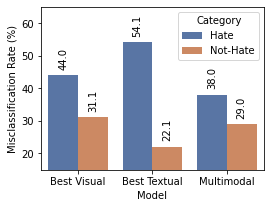

In [ ]:
model_names = ['Best Visual', 'Best Textual','Multimodal']
plt.figure(figsize=(4, 3))
#ax = plt.subplot()c
splot = sns.barplot(data=df,x='Models', y='Values' ,hue='Category',palette="deep")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 17),
                   textcoords = 'offset points',
                   rotation= 90)

plt.xlabel('Model')
plt.ylabel('Misclassification Rate (%)')
#plt.title('Classwise Misclassification Rate')
plt.ylim([15,65])
plt.xticks([0,1,2],model_names ,rotation = '0')
plt.savefig('ms-rate.png',dpi = 500,bbox_inches ='tight')